In [1]:
#TODO: #1: task A -> kivagni a reszleteket (pl 2 kornyezet) es ugy kiertekelni (tokeneket es egesz szoveget is)
#TODO: #2: ezutan magyar nyelvu adatbazisra kiprobalni ugyanezt (task A-hoz hasonlo)
#TODO: #3: ha nyaron marad ido, akkor gloVe-on kivul uj contextus fuggo szobeagyazasok (pl BERT)

import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

USE_STOPWORDS = False
TRAIN_RANDOM_STATE = 42
DEV_RANDOM_STATE = 42
SGD_RANDOM_STATE = 42
SGD_MAX_ITER = 1000

all_stopwords = []

In [2]:
import logging

FORMAT = '%(asctime)-15s %(levelname)s:\t%(message)s'
handle = 'bag_of_words'

logging.root.setLevel(logging.NOTSET)
logging.basicConfig(format=FORMAT, level=logging.NOTSET)
logger = logging.getLogger(handle)

In [3]:
from sklearn.utils import shuffle

HEADER = ['id1', 'id2', 'sentiment', 'tweet_text']
HEADER_TO_DELETE = ['id1', 'id2']

def clean(dataset, col='tweet_text', not_equals_text='Not Available'):
    return dataset[dataset[col] != not_equals_text]

def remove_mentions(input_text):
    input_text = re.sub(r'@\w+', '', input_text)
    return re.sub(r'#\w+', '', input_text)

def merge_neutrals(dataset):
    neutral_sentiments = ['objective', 'objective-OR-neutral']
    dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 'neutral' if x in neutral_sentiments else x)
    return dataset


train_dataset = pd.read_csv('db/train.tsv', sep='\t', header=None, names=HEADER)
train_dataset = shuffle(train_dataset, random_state=TRAIN_RANDOM_STATE)
train_dataset = clean(train_dataset)
train_dataset = merge_neutrals(train_dataset)
train_dataset.drop(HEADER_TO_DELETE, axis=1, inplace=True)
train_dataset['tweet_text'] = train_dataset['tweet_text'].apply(remove_mentions)
train_dataset.info()

dev_dataset = pd.read_csv('db/dev-full.tsv', sep='\t', header=None, names=HEADER)
dev_dataset = shuffle(dev_dataset, random_state=DEV_RANDOM_STATE)
dev_dataset = clean(dev_dataset)
dev_dataset = merge_neutrals(dev_dataset)
dev_dataset.drop(HEADER_TO_DELETE, axis=1, inplace=True)
dev_dataset['tweet_text'] = dev_dataset['tweet_text'].apply(remove_mentions)
dev_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6275 entries, 5821 to 7270
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   6275 non-null   object
 1   tweet_text  6275 non-null   object
dtypes: object(2)
memory usage: 147.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 65 to 1126
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   1051 non-null   object
 1   tweet_text  1051 non-null   object
dtypes: object(2)
memory usage: 24.6+ KB


In [4]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate(predict, labels):
    print('Classification report:')
    print(classification_report(labels, predict))
    print('Accuracy:')
    print(accuracy_score(labels, predict))

    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(labels, predict),
                         index=[i for i in ['positive', 'neutral', 'negative']],
                         columns=[i for i in ['positive', 'neutral', 'negative']])
    plt.figure(figsize=(10,7))
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    plt.show()

x_train = train_dataset['tweet_text'].values
y_train = train_dataset['sentiment'].values

x_dev = dev_dataset['tweet_text'].values
y_dev = dev_dataset['sentiment'].values

train_dataset.head(5)

,sentiment,tweet_text
5821,neutral,I'm bout to just listen to nicki minaj all night
2833,positive,I don't see C. Edwards doing anything but rac...
2543,positive,I fux wit yo 3rd choice but Gifted Hands (the...
1737,positive,"First time listing to Red: ""Does this diva thi..."
6582,positive,Congrats to Lloyd Robertson on the Gordon Sin...


In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords

USE_STOPWORDS = True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel_Janos_Robert\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from nltk import SnowballStemmer

URL_RE = 'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}([-a-zA-Z0-9()@:%_+.~#?&/=]*)'

def create_corpus_by_dataset(dataset):
    global all_stopwords
    corpus = []
    for i in dataset.index:
        tweet = re.sub(URL_RE, ' ', dataset['tweet_text'][i])
        tweet = re.sub('[^a-zA-Z]', ' ', tweet)
        tweet = tweet.lower().join()
        if USE_STOPWORDS:
            all_stopwords = stopwords.words('english')
            whitelist = ["n't", "not", "no"]
            tweet = [word for word in tweet if (word not in all_stopwords or word in whitelist)
                     and len(word) > 1]
        ps = SnowballStemmer('english')
        tweet = [ps.stem(word) for word in tweet]
        tweet = ' '.join(tweet)
        corpus.append(tweet)

    return corpus

x_train_clean = create_corpus_by_dataset(train_dataset)
print(x_train_clean)
x_dev_clean = create_corpus_by_dataset(dev_dataset)

['bout listen nicki minaj night', 'see edward anyth race hard thur duel sure smart though', 'fux wit yo rd choic gift hand ben carson stori alex haley autobiographi malcolm top', 'first time list red diva think avril lavign nd th time stop listen', 'congrat lloyd robertson gordon sinclair award tonight gemini last broadcast ctv nat news thursday', 'first coolamon rodeo come novemb great day action fun day famili', 'came back mexico citi fail subject not go school week rih come mexico th omg', 'bayer leverkusen win bayern munich apocalyps start tomorrow', 'belladonna zylona aladdin tonight come enjoy show hold hookah direct', 'rememb th round prospect made peopl question iupati abil senior bowl', 'silent hous guess love elizabeth olsen gotta find martha marci may marlen heard realli good', 'schedul today saturday quit possibl day trip no overnight stay beauti covina', 'sure tuesday noon et live und com nebraska know tune', 'rt gt gt rt milan bontet thing make happi last night', 'ok hope

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0.002) #ngram (1-3)
x_train_model = cv.fit_transform(x_train_clean)

In [8]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(random_state=SGD_RANDOM_STATE, max_iter=SGD_MAX_ITER, learning_rate='constant',
                           eta0=0.01)
classifier.fit(x_train_model, y_train)

SGDClassifier(eta0=0.01, learning_rate='constant', random_state=42)

2021-07-02 10:16:54,735 DEBUG:	locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000264AFD6B610>
2021-07-02 10:16:54,735 DEBUG:	Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000264AFD6B610> on colorbar
2021-07-02 10:16:54,736 DEBUG:	Setting pcolormesh
2021-07-02 10:16:54,750 DEBUG:	findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2021-07-02 10:16:54,752 DEBUG:	findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
2021-07-02 10:16:54,753 DEBUG:	findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
2021-07-02 10:16:54,753 DEBUG:	findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-07-02 10:16:54,754 DEBUG:	findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
2021-07-02 10:16:54,755 DEBUG:	findfont: 

Classification report:
              precision    recall  f1-score   support

    negative       0.51      0.24      0.32       205
     neutral       0.60      0.79      0.68       470
    positive       0.64      0.58      0.61       376

    accuracy                           0.61      1051
   macro avg       0.58      0.54      0.54      1051
weighted avg       0.60      0.61      0.59      1051

Accuracy:
0.6060894386298763
Confusion matrix:


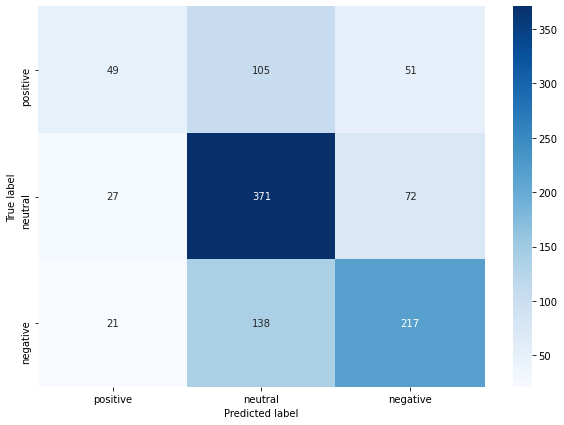

In [9]:
x_dev_model = cv.transform(x_dev_clean)

dev_predict = classifier.predict(x_dev_model)

evaluate(dev_predict, y_dev)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train_clean)

lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

LogisticRegression()

In [11]:
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print("feature numbers = " + str(len(sorted_coef_index)))
print('\nsmallest coef :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('largest coef : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

feature numbers = 10065

smallest coef :
['pm' 'love' 'happi' 'free' 'next' 'come' 'novemb' 'august' 'see' 'friday']

largest coef : 
['not' 'fuck' 'cancel' 'shit' 'hate' 'sorri' 'sad' 'bad' 'lost' 'kill']


Classification report:
              precision    recall  f1-score   support

    negative       0.59      0.13      0.21       205
     neutral       0.60      0.83      0.69       470
    positive       0.67      0.62      0.65       376

    accuracy                           0.62      1051
   macro avg       0.62      0.53      0.52      1051
weighted avg       0.62      0.62      0.58      1051

Accuracy:
0.6203615604186489
Confusion matrix:


2021-07-02 10:16:57,391 DEBUG:	locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000264B1659790>
2021-07-02 10:16:57,392 DEBUG:	Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000264B1659790> on colorbar
2021-07-02 10:16:57,393 DEBUG:	Setting pcolormesh


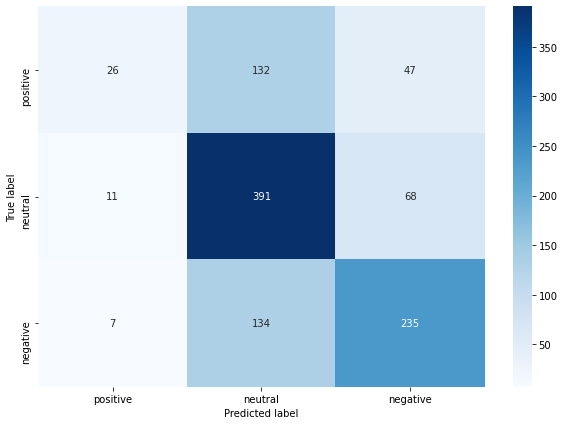

In [12]:
dev_predict = lr.predict(tfidf.transform(x_dev_clean))

evaluate(dev_predict, y_dev)